<a href="https://colab.research.google.com/github/DEBG14/Graph-Machine-Learning/blob/main/Dynamic_Link_Prediction_on_OGB_DDI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Link Prediction on Drug-Drug interaction dataset





In [1]:
import os
!pip install torch
!pip install torch-geometric #to install Python-Geometric (pyg)!
!pip install -q git+https://github.com/snap-stanford/deepsnap.git
!pip install -U -q PyDrive
!pip install ogb #needed for the dataset

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 59.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 7.8 MB/s eta 0:00:00


## Necessary Imports

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as pyg
from torch_geometric.data import DataLoader
from torch_geometric.utils import negative_sampling
from ogb.linkproppred import PygLinkPropPredDataset, Evaluator #needed to extract and evaluate the ogb-ddi dataset
import matplotlib.pyplot as plt #needed to visualize loss curves
import numpy as np

## Graph Neural Network Stack

Defining a GNNStack class to use GraphSAGE conv layers.

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as pyg

class GNNStack(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout, emb=False):
        """
        Graph Neural Network Stack based on GraphSAGE convolutional layers.

        Args:
            input_dim (int): Dimension of input features.
            hidden_dim (int): Dimension of hidden layers.
            output_dim (int): Dimension of output features.
            num_layers (int): Number of GraphSAGE layers.
            dropout (float): Dropout probability.
            emb (bool): If True, returns embeddings. Otherwise, returns class probabilities.
        """
        super(GNNStack, self).__init__()

        # Ensure the model has at least one layer
        assert num_layers >= 1, 'Number of layers must be at least 1'

        # Initialize the convolutional layers
        self.convs = nn.ModuleList()
        self.convs.append(pyg.nn.SAGEConv(input_dim, hidden_dim))  # First layer
        for _ in range(num_layers - 1):  # Additional layers
            self.convs.append(pyg.nn.SAGEConv(hidden_dim, hidden_dim))

        # Dropout probability
        self.dropout = dropout
        self.num_layers = num_layers

        # Flag for returning embeddings
        self.emb = emb

        # Post message-passing processing layers
        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x, edge_index):
        """
        Forward pass through the GNN stack.

        Args:
            x (torch.Tensor): Node features.
            edge_index (torch.Tensor): Edge indices.

        Returns:
            torch.Tensor: Log-softmax probabilities or embeddings.
        """
        # Apply each GraphSAGE layer
        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        # Apply post-message-passing processing
        x = self.post_mp(x)

        # Return embeddings if specified
        if self.emb:
            return x

        # Return log-softmax probabilities otherwise
        return F.log_softmax(x, dim=1)

    @staticmethod
    def loss(pred, label):
        """
        Compute the negative log likelihood loss.

        Args:
            pred (torch.Tensor): Predictions.
            label (torch.Tensor): Ground truth labels.

        Returns:
            torch.Tensor: Loss value.
        """
        return F.nll_loss(pred, label)


The LinkPredictor takes the embedding vector of 2 nodes ($x_i$, $x_j \in \mathbb{R}^d$ ) and computes the probability score of whether there exists a link between the 2 nodes.

$$\text{Probability of edge between node i and node j = MLP}(x_i\odot x_j)$$

Note: $x \odot y$ is the element-wise product (Hadamard product) of vectors $x$ and $y$

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LinkPredictor(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, dropout):
        """
        Link Predictor for graph-based models.

        Args:
            in_channels (int): Input feature dimension.
            hidden_channels (int): Dimension of hidden layers.
            out_channels (int): Output feature dimension.
            num_layers (int): Number of layers in the network.
            dropout (float): Dropout probability.
        """
        super(LinkPredictor, self).__init__()

        # Initialize linear layers
        self.lins = nn.ModuleList()
        self.lins.append(nn.Linear(in_channels, hidden_channels))  # First layer
        for _ in range(num_layers - 2):  # Intermediate layers
            self.lins.append(nn.Linear(hidden_channels, hidden_channels))
        self.lins.append(nn.Linear(hidden_channels, out_channels))  # Output layer

        # Dropout probability
        self.dropout = dropout

    def reset_parameters(self):
        """
        Reset parameters of all linear layers.
        """
        for lin in self.lins:
            lin.reset_parameters()

    def forward(self, x_i, x_j):
        """
        Forward pass through the link predictor.

        Args:
            x_i (torch.Tensor): Feature tensor for source nodes, shape (E, D).
            x_j (torch.Tensor): Feature tensor for target nodes, shape (E, D).

        Returns:
            torch.Tensor: Predicted link probabilities, shape (E, 1).
        """
        # Element-wise multiplication of source and target node features
        x = x_i * x_j

        # Pass through the hidden layers with ReLU and dropout
        for lin in self.lins[:-1]:
            x = lin(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        # Pass through the final layer and apply sigmoid
        x = self.lins[-1](x)
        return torch.sigmoid(x)


A GNN is trained by jointly maximizing the probabilty prediction of correct edges and minimizing the probability prediciton of the incorrect edges:

$Loss = -\log(prob\_pos\_edges  + ϵ) - \log(1-prob\_neg\_edges + ϵ)$ where the $ϵ=10^{-15}$ is added to each term for numerical stability

In [5]:
from torch_geometric.utils import negative_sampling
from torch.utils.data import DataLoader

def train(model, link_predictor, emb, edge_index, pos_train_edge, batch_size, optimizer):
    """
    Train the model and link predictor for link prediction.

    Args:
        model (torch.nn.Module): Graph model for message passing.
        link_predictor (torch.nn.Module): Model for predicting the existence of edges.
        emb (torch.Tensor): Initial node embeddings, shape (N, d).
        edge_index (torch.Tensor): Edge index for the graph, shape (2, E).
        pos_train_edge (torch.Tensor): Positive edges for training, shape (PE, 2).
        batch_size (int): Number of edges to sample per batch.
        optimizer (torch.optim.Optimizer): Optimizer for model parameters.

    Returns:
        float: Average loss over all positive and sampled negative edges.
    """
    model.train()
    link_predictor.train()

    # List to store losses for each batch
    train_losses = []

    # Iterate over batches of positive training edges
    for edge_id in DataLoader(range(pos_train_edge.shape[0]), batch_size, shuffle=True):
        optimizer.zero_grad()

        # Perform message passing to get updated node embeddings
        node_emb = model(emb, edge_index)  # Updated embeddings, shape (N, d)

        # Get the positive edges for the current batch
        pos_edge = pos_train_edge[edge_id].T  # Shape (2, B)
        pos_pred = link_predictor(node_emb[pos_edge[0]], node_emb[pos_edge[1]])  # Predictions, shape (B,)

        # Sample negative edges matching the batch size
        neg_edge = negative_sampling(
            edge_index=edge_index,
            num_nodes=emb.shape[0],
            num_neg_samples=edge_id.shape[0],
            method='dense'
        )  # Negative edges, shape (Ne, 2)
        neg_pred = link_predictor(node_emb[neg_edge[0]], node_emb[neg_edge[1]])  # Predictions, shape (Ne,)

        # Compute loss: Negative log-likelihood for positive and negative edges
        pos_loss = -torch.log(pos_pred + 1e-15).mean()
        neg_loss = -torch.log(1 - neg_pred + 1e-15).mean()
        loss = pos_loss + neg_loss

        # Backpropagate and update parameters
        loss.backward()
        optimizer.step()

        # Record the batch loss
        train_losses.append(loss.item())

    # Return the average loss over all batches
    return sum(train_losses) / len(train_losses)


The performance of a link predictor is evaluated through the metric Hits@K.

Hits@K = Fraction of correct links in the top K links based on score.

Note that a smaller K is a stricter metric.

In [6]:
def test(model, predictor, emb, edge_index, split_edge, batch_size, evaluator):
    """
    Evaluates the graph model on validation and test edges.

    Args:
        model (torch.nn.Module): Graph model for updating node embeddings via message passing.
        predictor (torch.nn.Module): Model for predicting edge existence.
        emb (torch.Tensor): Initial node embeddings, shape (N, d).
        edge_index (torch.Tensor): Edge index of the graph, shape (2, E).
        split_edge (dict): Dictionary containing validation and test positive/negative edges.
        batch_size (int): Number of edges per batch for evaluation.
        evaluator (ogb.linkproppred.Evaluator): Evaluator to calculate hits@K metrics.

    Returns:
        dict: Hits@K results for validation and test sets.
    """
    model.eval()
    predictor.eval()

    # Update node embeddings with message passing
    node_emb = model(emb, edge_index)

    # Move split edges to the same device as embeddings
    pos_valid_edge = split_edge['valid']['edge'].to(emb.device)
    neg_valid_edge = split_edge['valid']['edge_neg'].to(emb.device)
    pos_test_edge = split_edge['test']['edge'].to(emb.device)
    neg_test_edge = split_edge['test']['edge_neg'].to(emb.device)

    # Helper function to compute predictions for a set of edges
    def compute_predictions(edges):
        preds = []
        for perm in DataLoader(range(edges.size(0)), batch_size):
            edge = edges[perm].t()  # Shape (2, batch_size)
            preds.append(predictor(node_emb[edge[0]], node_emb[edge[1]]).squeeze().cpu())
        return torch.cat(preds, dim=0)

    # Compute predictions for validation and test edges
    pos_valid_pred = compute_predictions(pos_valid_edge)
    neg_valid_pred = compute_predictions(neg_valid_edge)
    pos_test_pred = compute_predictions(pos_test_edge)
    neg_test_pred = compute_predictions(neg_test_edge)

    # Evaluate hits@K for validation and test sets
    results = {}
    for K in [20, 50, 100]:
        evaluator.K = K

        valid_hits = evaluator.eval({
            'y_pred_pos': pos_valid_pred,
            'y_pred_neg': neg_valid_pred,
        })[f'hits@{K}']

        test_hits = evaluator.eval({
            'y_pred_pos': pos_test_pred,
            'y_pred_neg': neg_test_pred,
        })[f'hits@{K}']

        results[f'Hits@{K}'] = (valid_hits, test_hits)

    return results


## The OGB-ddi Dataset

In [7]:
dataset = PygLinkPropPredDataset(name="ogbl-ddi", root='./dataset/') #download the dataset

Downloaded 0.04 GB: 100%|██████████| 46/46 [00:20<00:00,  2.29it/s]


Extracting ./dataset/ddi.zip


Processing...


Loading necessary files...
This might take a while.
Processing graphs...


100%|██████████| 1/1 [00:00<00:00, 44.60it/s]


Converting graphs into PyG objects...


100%|██████████| 1/1 [00:00<00:00, 870.55it/s]

Saving...



Done!
/usr/local/lib/python3.10/dist-packages/ogb/linkproppred/dataset_pyg.py:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.pro

In [10]:
# Hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optim_wd = 0
epochs = 200
hidden_dim = 256
dropout = 0.3
num_layers = 2
lr = 3e-3
node_emb_dim = 256
batch_size = 64 * 1024

/usr/local/lib/python3.10/dist-packages/ogb/linkproppred/dataset_pyg.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train = replace_numpy_with_torchtensor(torch.load(o

Epoch 1: loss: 1.32804
Epoch 2: loss: 1.04563
Epoch 3: loss: 0.8954
Epoch 4: loss: 0.81818
Epoch 5: loss: 0.77834
Epoch 6: loss: 0.72365
Epoch 7: loss: 0.68076
Epoch 8: loss: 0.65032
Epoch 9: loss: 0.6328
Epoch 10: loss: 0.6046
{'Hits@20': (0.1915813287986276, 0.11221149308182697), 'Hits@50': (0.24962356448845974, 0.1929971757972567), 'Hits@100': (0.29360471649349384, 0.2467394317134745)}
Epoch 11: loss: 0.58337
Epoch 12: loss: 0.56269
Epoch 13: loss: 0.5469
Epoch 14: loss: 0.53365
Epoch 15: loss: 0.52165
Epoch 16: loss: 0.51356
Epoch 17: loss: 0.50346
Epoch 18: loss: 0.49085
Epoch 19: loss: 0.48061
Epoch 20: loss: 0.47604
{'Hits@20': (0.21031695495508992, 0.1183917775996524), 'Hits@50': (0.28432305283581416, 0.25518956618148314), 'Hits@100': (0.3854175250395164, 0.36411239877443086)}
Epoch 21: loss: 0.47024
Epoch 22: loss: 0.46005
Epoch 23: loss: 0.451
Epoch 24: loss: 0.44434
Epoch 25: loss: 0.43711
Epoch 26: loss: 0.42894
Epoch 27: loss: 0.42331
Epoch 28: loss: 0.41569
Epoch 29: loss

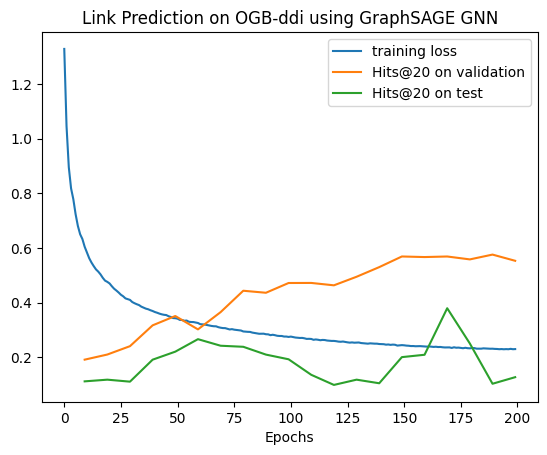

In [11]:
split_edge = dataset.get_edge_split()
pos_train_edge = split_edge['train']['edge'].to(device)

graph = dataset[0]
edge_index = graph.edge_index.to(device)

evaluator = Evaluator(name='ogbl-ddi')

emb = torch.nn.Embedding(graph.num_nodes, node_emb_dim).to(device) # each node has an embedding that has to be learnt
model = GNNStack(node_emb_dim, hidden_dim, hidden_dim, num_layers, dropout, emb=True).to(device) # the graph neural network that takes all the node embeddings as inputs to message pass and agregate
link_predictor = LinkPredictor(hidden_dim, hidden_dim, 1, num_layers + 1, dropout).to(device) # the MLP that takes embeddings of a pair of nodes and predicts the existence of an edge between them

optimizer = torch.optim.Adam(
    list(model.parameters()) + list(link_predictor.parameters()) + list(emb.parameters()),
    lr=lr, weight_decay=optim_wd
)

train_loss = []
val_hits = []
test_hits = []
for e in range(epochs):
    loss = train(model, link_predictor, emb.weight, edge_index, pos_train_edge, batch_size, optimizer)
    print(f"Epoch {e + 1}: loss: {round(loss, 5)}")
    train_loss.append(loss)

    if (e+1)%10 ==0:
        result = test(model, link_predictor, emb.weight, edge_index, split_edge, batch_size, evaluator)
        val_hits.append(result['Hits@20'][0])
        test_hits.append(result['Hits@20'][1])
        print(result)

plt.title('Link Prediction on OGB-ddi using GraphSAGE GNN')
plt.plot(train_loss,label="training loss")
plt.plot(np.arange(9,epochs,10),val_hits,label="Hits@20 on validation")
plt.plot(np.arange(9,epochs,10),test_hits,label="Hits@20 on test")
plt.xlabel('Epochs')
plt.legend()
plt.show()

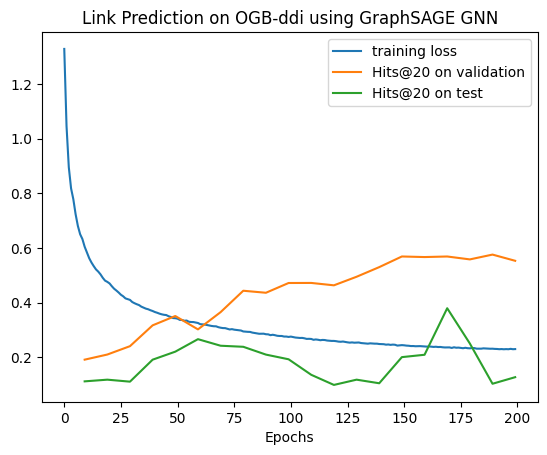

In [12]:
plt.title('Link Prediction on OGB-ddi using GraphSAGE GNN')
plt.plot(train_loss,label="training loss")
plt.plot(np.arange(9,epochs,10),val_hits,label="Hits@20 on validation")
plt.plot(np.arange(9,epochs,10),test_hits,label="Hits@20 on test")
plt.xlabel('Epochs')
plt.legend()
plt.show()

# Link prediction on unseen new nodes (prediction on dynamic graph)

Preprocesing the dataset to the online setting. Each online node is stored with a collection of its message passing, supervison, validation, test edges and negative edges together in a dictionary.

In [13]:
import pickle

class NoEdgeException(Exception):
    pass


def create_online_edge_index(n_id, full_edge_index, curr_edge_index, curr_nodes, rng,
                             train_msg=0.4, train_sup=0.4, val_pct=0.1):
    """
    Creates the train/val/test positive and negative edge index for online node id n_id,
    given the split ratios for training message/supervision, and val and test edges
    :param n_id: Node index for the online node being considered
    :param full_edge_index: (2, E) tensor of ALL edges in the full graph
    :param curr_edge_index: (2, Ec) tensor of edges in the current subgraph
    :param curr_nodes: (N,) tensor of node indices in the current subgraph
    :param rng: numpy random number generator
    :param train_msg: Percentage of n_id's edges that will be used for train message passing
    :param train_sup: Percentage of n_id's edges that will be used for train loss supervision
    :param val_pct: Percentage of n_id's edges that will be used for validation metrics
    :return:
        (2, E_new) tensor of edges in the subgraph updated with node n_id's message edges
        (N+1,) tensor of nodes in the subgraph updated with node n_id
        dict(key, (E, 2) Tensor) of train msg/sup/neg edges, val pos/neg edges, test pos/neg edges
    """
    curr_edges = curr_edge_index.T  # (CE, 2)
    edges = full_edge_index.T  # (E, 2)

    # First search for all edges containing node id
    # since undirected, both (i,j) and (j, i) should be in edges
    all_node_edges = edges[edges[:, 0] == n_id]  # (D_all, 2)

    # Then, only keep edges from node_id to nodes in current graph
    node_edges = torch.isin(all_node_edges[:, 1], curr_nodes)  # (D_all,)
    node_edges = all_node_edges[node_edges]  # (D, 2)
    node_edges = node_edges[rng.permutation(node_edges.shape[0])]  # (D, 2)
    D = node_edges.shape[0]

    # Create negative edges
    neg_edges = []
    for n in curr_nodes:
        if not torch.isin(n, node_edges):
            neg_edges.append((n_id, n))
    neg_edges = torch.as_tensor(neg_edges, dtype=torch.long)  # (Ne, 2)
    neg_edges = neg_edges[rng.permutation(neg_edges.shape[0])]  # (Ne, 2)

    # Then, split node edges into train/val/test
    train_msg_range = (0, int(train_msg * D))
    train_sup_range = (train_msg_range[1], train_msg_range[1] + int(train_sup * D))
    val_range = (train_sup_range[1], train_sup_range[1] + int(val_pct * D))
    test_range = (val_range[1], D)

    split = {
        'train_msg': node_edges[train_msg_range[0]:train_msg_range[1]],  # (TrMsg, 2)
        'train_sup': node_edges[train_sup_range[0]:train_sup_range[1]],  # (TrSup, 2)
        'valid': node_edges[val_range[0]:val_range[1]],  # (Val, 2)
        'test': node_edges[test_range[0]:test_range[1]]  # (Test, 2)
    }

    # Keep same number of neg edges for val/test as pos edges, give remaining to train
    val_neg_range = (0, split['valid'].shape[0])
    test_neg_range = (split['valid'].shape[0], split['valid'].shape[0] + split['test'].shape[0])
    train_neg_range = (split['valid'].shape[0] + split['test'].shape[0], neg_edges.shape[0])

    split['valid_neg'] = neg_edges[val_neg_range[0]:val_neg_range[1]]  # (Val, 2)
    split['test_neg'] = neg_edges[test_neg_range[0]:test_neg_range[1]]  # (Val, 2)
    split['train_neg'] = neg_edges[train_neg_range[0]:train_neg_range[1]]  # (Val, 2)

    # Msg edges need both (i,j) and (j,i)
    split['train_msg'] = split['train_msg'].repeat_interleave(2, dim=0)
    split['train_msg'][::2] = split['train_msg'][::2].flip(1)

    for k, edges in split.items():
        if len(edges) == 0:
            raise NoEdgeException(f"Warning: node {n_id} has no {k} edges")
            # print(f"Warning: node {n_id} has no {k} edges")

    return torch.cat((curr_edges, split['train_msg']), dim=0).T, \
           torch.cat((curr_nodes, torch.as_tensor([n_id]))), \
           split


def preprocess(outfile, init_cluster_size=1000, num_online=None, seed=0,
               split_train_msg=0.4, split_train_sp=0.4, split_val=0.1):
    """
    Creates a dataset with an initial subgraph and a dictionary of online nodes
    :param outfile: path to .pkl file where dataset will be saved
    :param init_cluster_size: Number of nodes in initial subgraph
    :param num_online: Number of nodes considered in online setting
    :param seed: Numpy random number generator seed
    :param split_train_msg: Percentage of each online node's edges used for train message passing
    :param split_train_sp: Percentage of each online node's edges used for train loss supervision
    :param split_val: Percentage of each online node's edges used for validation metrics
    :return:
    """
    rng = np.random.default_rng(seed)

    dataset = PygLinkPropPredDataset(name="ogbl-ddi", root='./dataset/')
    split_edge = dataset.get_edge_split()

    graph = dataset[0]
    edge_index = graph.edge_index.T  # (TrE, 2)

    # All train edges are in edge_index. None of val or test edges are in edge_index
    val_edges = split_edge['valid']['edge'].repeat_interleave(2, dim=0)
    val_edges[::2] = val_edges[::2].flip(1)
    test_edges = split_edge['test']['edge'].repeat_interleave(2, dim=0)
    test_edges[::2] = test_edges[::2].flip(1)
    full_index = torch.cat((edge_index, val_edges, test_edges), dim=0)  # (E, 2)

    nodes = np.arange(graph.num_nodes)
    node_map = np.arange(len(nodes))
    rng.shuffle(node_map)

    # old_to_new[i] = new idx of node i in new ordering of nodes
    new_from_old = torch.from_numpy(node_map[node_map])
    old_from_new = torch.from_numpy(node_map)

    # Map edges to new ordering of nodes (where new node 0 = node_map[0])
    full_index = new_from_old[full_index].T  # (2, E)

    # Initial node induced subgraph of all (keeps the interleaved structure)
    init_nodes = torch.arange(init_cluster_size)
    init_edge_index, _ = pyg.utils.subgraph(init_nodes, full_index)  # (2, InitEdges)

    num_online = num_online if num_online is not None else len(nodes) - init_cluster_size
    online_nodes = torch.arange(init_cluster_size, init_cluster_size + num_online)

    # For online nodes, find edges that connect node to current subgraph.
    # Add the online node's training message edges to the current subgraph to update the curr edge_index
    # Add the node's training, val, test edges to the online node dictionary
    curr_nodes = init_nodes
    curr_edge_index = init_edge_index
    online_node_edge_index = {}
    for n in online_nodes.numpy():
        try:
            curr_edge_index, curr_nodes, node_split = \
                create_online_edge_index(n, full_index, curr_edge_index, curr_nodes, rng, split_train_msg,
                                         split_train_sp, split_val)
        except NoEdgeException as e:
            print(str(e))
            continue
        online_node_edge_index[n] = node_split

    # Save the graph info
    dataset = {
        "init_nodes": init_nodes,
        "init_edge_index": init_edge_index,
        "online": online_node_edge_index,
        "full_edge_index": full_index,
    }

    with open(outfile, 'wb') as f:
        pickle.dump(dataset, f)



In [14]:
# ---------------------------------------------------- #
# Hyper parameters
init_size = 1000
num_online = 10
seed = 0
split_train_msg = 0.4
split_train_sp = 0.4
split_val = 0.1

split_test = round(1.0 - split_train_msg - split_train_sp - split_val,2)
file_name = f"online_init:{init_size}-online_nodes:{num_online}-split:{split_train_msg}_{split_train_sp}_{split_val}_{split_test}-seed:{seed}.pkl"
file_name = os.path.join('dataset', file_name)

preprocess(file_name, init_size, num_online, seed, split_train_msg, split_train_sp, split_val)

/usr/local/lib/python3.10/dist-packages/ogb/linkproppred/dataset_pyg.py:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.processed_

In [15]:
def online_train(model, link_predictor, emb, edge_index, pos_train_edge, neg_train_edges,
                 batch_size, optimizer, device):
    """
    Runs training for a single online node given its edges to the existing subgraph
    :param model: Torch Graph model used for updating node embeddings based on message passing
    :param link_predictor: Torch model used for predicting whether edge exists or not
    :param emb: (N+1, d) Initial node embeddings for all N nodes in subgraph, along with new online node
    :param edge_index: (2, E) Edge index for edges in subgraph, along with message edges for online node
    :param pos_train_edge: (PE, 2) Positive edges from online node to subgraph, for supervision loss
    :param neg_train_edges: (NE, 2) All training negative edges from online node to subgraph.
        (Equal number of negative edges will be sampled as the number of positive edges for batch)
    :param batch_size: Number of positive (and negative) supervision edges to sample per batch
    :param optimizer: Torch Optimizer to update model parameters
    :param device: PyTorch device
    :return: Average supervision loss over all positive (and correspondingly sampled negative) edges
    """
    model.train()
    link_predictor.train()

    train_losses = []

    for edge_id in DataLoader(range(pos_train_edge.shape[0]), batch_size, shuffle=True):
        optimizer.zero_grad()

        # Run message passing on the inital node embeddings to get updated embeddings
        node_emb = model(emb, edge_index)  # (N, d)

        # Predict the class probabilities on the batch of positive edges using link_predictor
        pos_edge = pos_train_edge[edge_id].T  # (2, B)
        pos_pred = link_predictor(node_emb[pos_edge[0]], node_emb[pos_edge[1]])  # (B, )

        # Here we are given negative edges, so sample same number as pos edges and predict probabilities
        neg_idx = np.random.choice(len(neg_train_edges), batch_size, replace=False)
        neg_edge = neg_train_edges[torch.from_numpy(neg_idx).to(device)]  # (Ne, 2)
        neg_pred = link_predictor(node_emb[neg_edge[0]], node_emb[neg_edge[1]])  # (Ne,)

        # Compute the corresponding negative log likelihood loss on the positive and negative edges
        loss = -torch.log(pos_pred + 1e-15).mean() - torch.log(1 - neg_pred + 1e-15).mean()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    return sum(train_losses) / len(train_losses)

Accuracy is used here as, in the context of predicting interactions for a new drug.

In [16]:
def online_eval(model, link_predictor, emb, edge_index, pos_edges, neg_edges, batch_size):
    """
    Evaluates model on positive and negative edges for prediction
    :param model: Torch Graph model used for updating node embeddings based on message passing
    :param link_predictor: Torch model used for predicting whether edge exists or not
    :param emb: (N+1, d) Initial node embeddings for all N nodes in subgraph, along with new online node
    :param edge_index: (2, E) Edge index for edges in subgraph, along with message edges for online node
    :param pos_edges: (PE, 2) Positive edges from online node to subgraph (previously unseen)
    :param neg_edges: (PE, 2) Negative edges from online node to subgraph (previously unseen)
    :param batch_size: Number of positive (and negative) supervision edges to sample per batch
    :return: true positives, true negatives, false positives, false negatives, and
        dict(true positive edges, false positive edges, false negative edges)
    """
    model.eval()
    link_predictor.eval()

    tp = 0.
    tn = 0.
    fp = 0.
    fn = 0.
    for edge_id in DataLoader(range(pos_edges.shape[0]), batch_size, shuffle=False, drop_last=False):
        node_emb = model(emb, edge_index)  # (N, d)

        pos_edge = pos_edges[edge_id].T  # (2, B)
        pos_pred = link_predictor(node_emb[pos_edge[0]], node_emb[pos_edge[1]]).squeeze()  # (B, )

        tp += (pos_pred >= 0.5).sum().item()
        fn += (pos_pred < 0.5).sum().item()

    for edge_id in DataLoader(range(neg_edges.shape[0]), batch_size, shuffle=False, drop_last=False):
        node_emb = model(emb, edge_index)  # (N, d)

        neg_edge = neg_edges[edge_id].T  # (2, B)
        neg_pred = link_predictor(node_emb[neg_edge[0]], node_emb[neg_edge[1]]).squeeze()  # (B, )

        fp += (neg_pred >= 0.5).sum().item()
        tn += (neg_pred < 0.5).sum().item()

    return tp, tn, fp, fn

In [17]:
# Hyperparameters for the Online Link Predictor
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

path_to_dataset = './dataset/online_init:1000-online_nodes:10-split:0.4_0.4_0.1_0.1-seed:0.pkl'

hidden_dim = 32
dropout = 0.5
num_layers = 4
optim_wd = 0

init_train_epochs = 200
num_online_steps = 10
init_lr = 1e-2
online_lr = 1e-2
node_emb_dim = 256
init_batch_size = 1024 * 64
online_batch_size = 32

# Get dataset
with open(path_to_dataset, 'rb') as f:
    dataset = pickle.load(f)

init_nodes = dataset['init_nodes'].to(device)
init_edge_index = dataset['init_edge_index'].to(device)
init_pos_train = init_edge_index[:, ::2].to(device)  # Relying on interleaved order

online_node_edge_index = dataset['online']

In [18]:
# Create embedding, model, and optimizer
emb = torch.nn.Embedding(len(init_nodes) + max(online_node_edge_index) + 1, node_emb_dim).to(device)
model = GNNStack(node_emb_dim, hidden_dim, hidden_dim, num_layers, dropout, emb=True).to(device)
link_predictor = LinkPredictor(hidden_dim, hidden_dim, 1, num_layers + 1, dropout).to(device)

optimizer = torch.optim.Adam(
    list(model.parameters()) + list(link_predictor.parameters()) + list(emb.parameters()),
    lr=init_lr, weight_decay=optim_wd
)

# Train on initial subgraph
for e in range(init_train_epochs):
    loss = train(model, link_predictor, emb.weight[:len(init_nodes)], init_edge_index, init_pos_train.T,
                    init_batch_size, optimizer)
    print(f"Epoch {e + 1}/{init_train_epochs}: Loss = {round(loss, 5)}")

Epoch 1/200: Loss = 1.38696
Epoch 2/200: Loss = 1.38701
Epoch 3/200: Loss = 1.38659
Epoch 4/200: Loss = 1.38614
Epoch 5/200: Loss = 1.38126
Epoch 6/200: Loss = 1.34373
Epoch 7/200: Loss = 1.28781
Epoch 8/200: Loss = 1.26052
Epoch 9/200: Loss = 1.23585
Epoch 10/200: Loss = 1.19904
Epoch 11/200: Loss = 1.17847
Epoch 12/200: Loss = 1.11448
Epoch 13/200: Loss = 1.10097
Epoch 14/200: Loss = 1.08747
Epoch 15/200: Loss = 1.05085
Epoch 16/200: Loss = 1.04489
Epoch 17/200: Loss = 1.01006
Epoch 18/200: Loss = 0.99218
Epoch 19/200: Loss = 0.98166
Epoch 20/200: Loss = 0.94768
Epoch 21/200: Loss = 0.93336
Epoch 22/200: Loss = 0.94301
Epoch 23/200: Loss = 0.92861
Epoch 24/200: Loss = 0.9183
Epoch 25/200: Loss = 0.92884
Epoch 26/200: Loss = 0.92261
Epoch 27/200: Loss = 0.91151
Epoch 28/200: Loss = 0.90776
Epoch 29/200: Loss = 0.90473
Epoch 30/200: Loss = 0.89035
Epoch 31/200: Loss = 0.88624
Epoch 32/200: Loss = 0.89039
Epoch 33/200: Loss = 0.87502
Epoch 34/200: Loss = 0.88991
Epoch 35/200: Loss = 0.8

In [19]:
# New optimizer for online learning (GraphSAGE parameters are not updated to showcase its inductive capability)
optimizer = torch.optim.Adam(
    list(link_predictor.parameters()) + list(emb.parameters()),
    lr=init_lr, weight_decay=optim_wd
)

curr_nodes = init_nodes
curr_edge_index = init_edge_index  # (2, E)
for n_id, node_split in online_node_edge_index.items():
    train_msg, train_sup, train_neg, valid, valid_neg, test, test_neg = \
        node_split['train_msg'], node_split['train_sup'], node_split['train_neg'], \
        node_split['valid'], node_split['valid_neg'], node_split['test'], node_split['test_neg']

    train_msg = train_msg.to(device)
    train_sup = train_sup.to(device)
    train_neg = train_neg.to(device)
    valid = valid.to(device)
    valid_neg = valid_neg.to(device)
    test = test.to(device)
    test_neg = test_neg.to(device)

    # Add message edges to edge index
    curr_edge_index = torch.cat((curr_edge_index, train_msg.T), dim=1)  # (2, E+Tr_msg)

    # Add new node to list of curr_nodes
    curr_nodes = torch.cat((curr_nodes, torch.as_tensor([n_id], device=device)))

    with torch.no_grad():
        emb.weight[n_id] = emb.weight[curr_nodes].mean(dim=0)

    # Nodes are ordered sequentially (online node ids start at len(init_nodes))
    for t in range(num_online_steps):
        loss = online_train(model, link_predictor, emb.weight[:n_id + 1],
                            curr_edge_index, train_sup, train_neg, online_batch_size, optimizer, device)
        print(f"Step {t + 1}/{num_online_steps}: loss = {round(loss, 5)}")

    print(f"For node {n_id}:")
    val_tp, val_tn, val_fp, val_fn = online_eval(model, link_predictor, emb.weight[:n_id + 1],
                                                    curr_edge_index, valid, valid_neg, online_batch_size)

    print(f"VAL accuracy: {(val_tp + val_tn) / (val_tp + val_tn + val_fp + val_fn)}")
    print(f"VAL tp: {val_tp}, fn: {val_fn}, tn: {val_tn}, fp: {val_fp}")

    test_tp, test_tn, test_fp, test_fn = online_eval(model, link_predictor, emb.weight[:n_id + 1],
                                                        curr_edge_index, valid, test_neg, online_batch_size)

    print(f"TEST accuracy: {(test_tp + test_tn) / (test_tp + test_tn + test_fp + test_fn)}")
    print(f"TEST tp: {test_tp}, fn: {test_fn}, tn: {test_tn}, fp: {test_fp}")

Step 1/10: loss = 6.10691
Step 2/10: loss = 1.0313
Step 3/10: loss = 0.9261
Step 4/10: loss = 2.3064
Step 5/10: loss = 5.60391
Step 6/10: loss = 1.20529
Step 7/10: loss = 1.53706
Step 8/10: loss = 1.22571
Step 9/10: loss = 2.1116
Step 10/10: loss = 1.92969
For node 1000:
VAL accuracy: 0.5
VAL tp: 1.0, fn: 0.0, tn: 0.0, fp: 1.0
TEST accuracy: 0.25
TEST tp: 1.0, fn: 0.0, tn: 0.0, fp: 3.0
Step 1/10: loss = 0.71629
Step 2/10: loss = 2.41649
Step 3/10: loss = 0.91066
Step 4/10: loss = 18.24213
Step 5/10: loss = 1.03426
Step 6/10: loss = 2.31247
Step 7/10: loss = 0.95006
Step 8/10: loss = 1.24413
Step 9/10: loss = 1.65607
Step 10/10: loss = 0.46549
For node 1001:
VAL accuracy: 0.5
VAL tp: 1.0, fn: 0.0, tn: 0.0, fp: 1.0
TEST accuracy: 0.25
TEST tp: 1.0, fn: 0.0, tn: 0.0, fp: 3.0
Step 1/10: loss = 1.17294
Step 2/10: loss = 4.82819
Step 3/10: loss = 1.14879
Step 4/10: loss = 1.47433
Step 5/10: loss = 0.92688
Step 6/10: loss = 18.0236
Step 7/10: loss = 7.87592
Step 8/10: loss = 1.5821
Step 9/10: